# Experiments

This first notebook shows some of the experiments that took place in order to find a suitable text classifier for the three proposed categories:
+ `support`
+ `sales`
+ `joke`

## Creating a dataset

The first step is to create a small dataset with some samples from the different categories. I used ChatGPT (with the web chat interface) to accomplish that. I asked it to provide me sample sentences for the three different categories. The goal was not to create a complete or perfectly precised dataset, but to generate some sample sentences that could be used to quickly test our models and iterate upon.

These tiny dataset is found on `samples.py`. The next cell shows some sample sentences from the dataset.

In [1]:
from samples import samples
import random

N = 3

for k in samples.keys():
    print(f"Some random samples for category '{k}'")
    for sample in random.sample(samples[k], N):
        print(f"+ {sample}")
    print()

Some random samples for category 'support'
+ How can I check the warranty status of my recently purchased product?
+ My account shows a double charge for the same order. Can you help resolve this issue?
+ Are there any known issues with your website or services currently?

Some random samples for category 'sales'
+ I'm a photographer looking for a high-quality camera. What models do you suggest?
+ What are the key features of the latest smartwatches in your collection?
+ Are there any upcoming sales or promotions I should wait for before making a purchase?

Some random samples for category 'joke'
+ How do robots pay for things? With cache, of course!
+ Why did the robot go on a diet? It had too many bytes!
+ What do you call a robot that likes to take naps? A recharger!



## Find a suitable text classifier

In order to classify the text, we first need to find a text classifier that can do the job.

Because we have no initial dataset with the type of data that we want to classify, I think the best way to approach this classification task is by using some 0-shot classifiers. So, we don't actually need to fine-tune any model, but just provide the names of the categories. We can have a list of [0-shot classifiers in the hub](https://huggingface.co/models?pipeline_tag=zero-shot-classification&sort=trending).

Here we used the following models and compare them to classify the sentences in our dataset.

In [2]:
model_names = [
    "typeform/distilbert-base-uncased-mnli",
    'navteca/bart-large-mnli',
    'cross-encoder/nli-distilroberta-base',
    "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
    "MoritzLaurer/multilingual-MiniLMv2-L6-mnli-xnli"
]

In [3]:
import transformers
from transformers import pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

transformers.logging.set_verbosity_error()

/home/grego/code/jobsearch/ipglobal-2/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create dataset and some utility functions.

In [4]:
def long_to_short(label):
    return labels[explanatory_labels.index(label)]

def test_classifier(classifier, dataset):
    predictions = []
    for sentence, true_label in dataset:
        output = classifier(sentence, explanatory_labels, multi_label=False)
        pred_label = long_to_short(output['labels'][0])
        predictions.append(pred_label)
    return predictions


explanatory_labels = ["customer support", "sales & commercial", "joke & funny & comedy"]
labels = ["support", "sales", "joke"]

labels_list = list(samples.keys())
tiny_dataset = []
for label in labels_list:
    category_samples = [(sentence, label) for sentence in samples[label]]
    tiny_dataset.extend(category_samples)

Finally, run all the models for the test samples on our dataset and compare their performances using a confusion matrix. It can take a while.

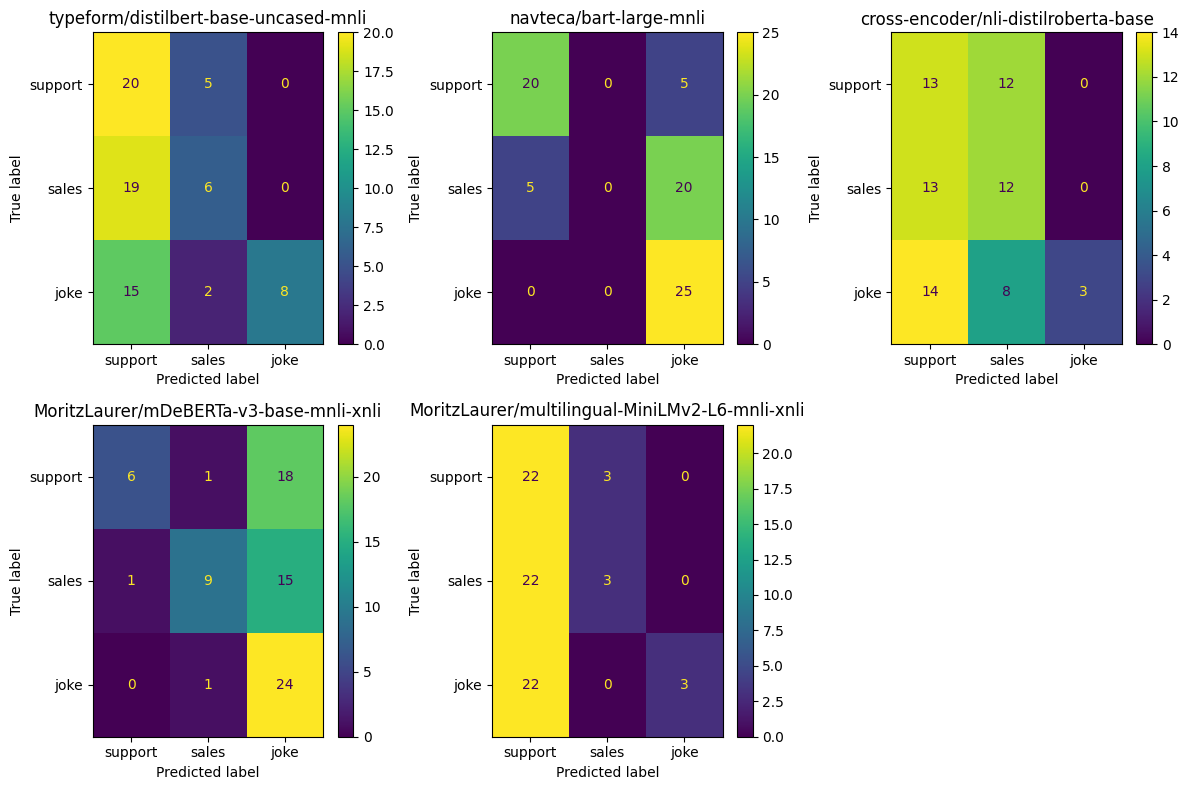

In [5]:
y_test = [label for _, label in tiny_dataset]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
for name, ax in zip(model_names, axs.flat):
    classifier = pipeline('zero-shot-classification', model=name)
    predictions = test_classifier(classifier, tiny_dataset)
    cm = confusion_matrix(y_test, predictions, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    plot = disp.plot(ax=ax)
    ax.set_aspect('auto')
    ax.set_title(name)

# delete last (unused subplot) and show
fig.delaxes(axs[-1][-1])
plt.tight_layout()
plt.show()

## Searching for something better

At that point I was disappointed with the performance of the models. Those were some of the 'best' or at least most used/liked models on the Hub. But none of them was achieving a good accuracy. I even tried several combinations of categories in `explanatory_labels` but nothing fixed it.

Thus, I thought that it was worth to try also to use `phi-2` as a 0-shot text classifier. Indeed, we can use an LLM as a text classifier by indicating it the names of the categories and a broad definition of the type of text that should fit in it.

In [6]:
import torch
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    StoppingCriteria, 
    StoppingCriteriaList, 
    TextIteratorStreamer
    )

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Your device is", device)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2", 
    device_map="auto", 
    torch_dtype="auto" if device == "cuda" else torch.float, 
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/phi-2", trust_remote_code=True)

Your device is cuda


Loading checkpoint shards: 100%|██████████████████| 2/2 [00:00<00:00,  2.02it/s]


In [8]:
class StopOnTokens(StoppingCriteria):
    """Stops the model if it produces an 'end of text' token"""
    def __call__(self, input_ids: torch.LongTensor, 
                 scores: torch.FloatTensor, **kwargs) -> bool:
        stop_ids = [50256, 198] # <|endoftext|> and EOL
        for stop_id in stop_ids:
            if input_ids[0][-1] == stop_id:
                return True
        return False

stop = StopOnTokens()

def run_prompt(prompt):
    with torch.no_grad():
        inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False).to(device)
        outputs = model.generate(**inputs, max_length=250, stopping_criteria=[stop])
        text = tokenizer.batch_decode(outputs)[0]
    return text

In [9]:
template = """
Instruct: Classify the following text in one of the following categories: ["support", "sales", "joke"]. Output only the name of the category.
+ "support" for customer support texts
+ "sales" for sales and commercial texts
+ "joke" for jokes, funny or comedy like texts
Text: {}
Output:
""".strip()

Next cell runs the prompt on all the sample sentences. It could take a while if it's the first time you load the model.

In [10]:
predictions = []
for i, (sentence, true_label) in enumerate(tiny_dataset):
    prompt = template.format(sentence)
    label = run_prompt(prompt).split()[-1]
    print(f"{i+1}/{len(tiny_dataset)}", end="\r")
    predictions.append(label)

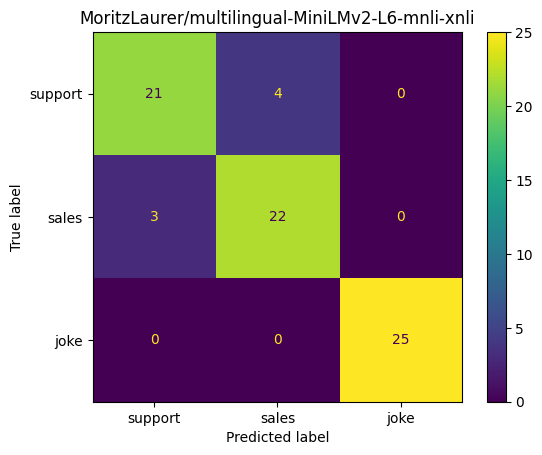

In [11]:
cm = confusion_matrix(y_test, predictions, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plot = disp.plot()
plot.ax_.set_title(name)
plt.show()

As we can see, the performance of `phi-2` as a 0-shot language classifier is similar to `navteca/bart-large-mnli` (maybe even slightly better). In that case we choose to use `phi-2` and not having to deploy yet another language model for classification.